## GeoPandas Data

In [ ]:
import pandas as pd

In [ ]:
# 도로
road = gpd.read_file('/content/도로/Z_UPIS_C_UQ151.shp', encoding='euc=kr')
road = road.to_crs(epsg=5179)

In [ ]:
# 읍면동
emd = gpd.read_file('/content/읍면동/emd.shp',encoding = 'euc-kr')
# 시군구
sig = gpd.read_file('/content/시군구/sig.shp',encoding = 'euc-kr')

In [ ]:
# 좌표계 설정
emd = emd.set_crs(epsg=5179)
sig = sig.set_crs(epsg=5179)

In [ ]:
# 좌표계 변환
emd = emd.to_crs(epsg=4326)
sig = sig.to_crs(epsg=4326)

In [ ]:
# 시군구 코드 베이스로 추출
## 천안시 동남구 : 44131
## 천안시 서북구 : 44133
## 아산시 44200
cheonan_streets = road[road['SIGNGU_SE'].str.startswith(('4413', '44200'))]
cheonan_streets.shape

In [ ]:
cheonan = emd[emd['EMD_CD'].str.startswith(('44131', '44133','44200'))]
cheonan.shape

<Axes: >

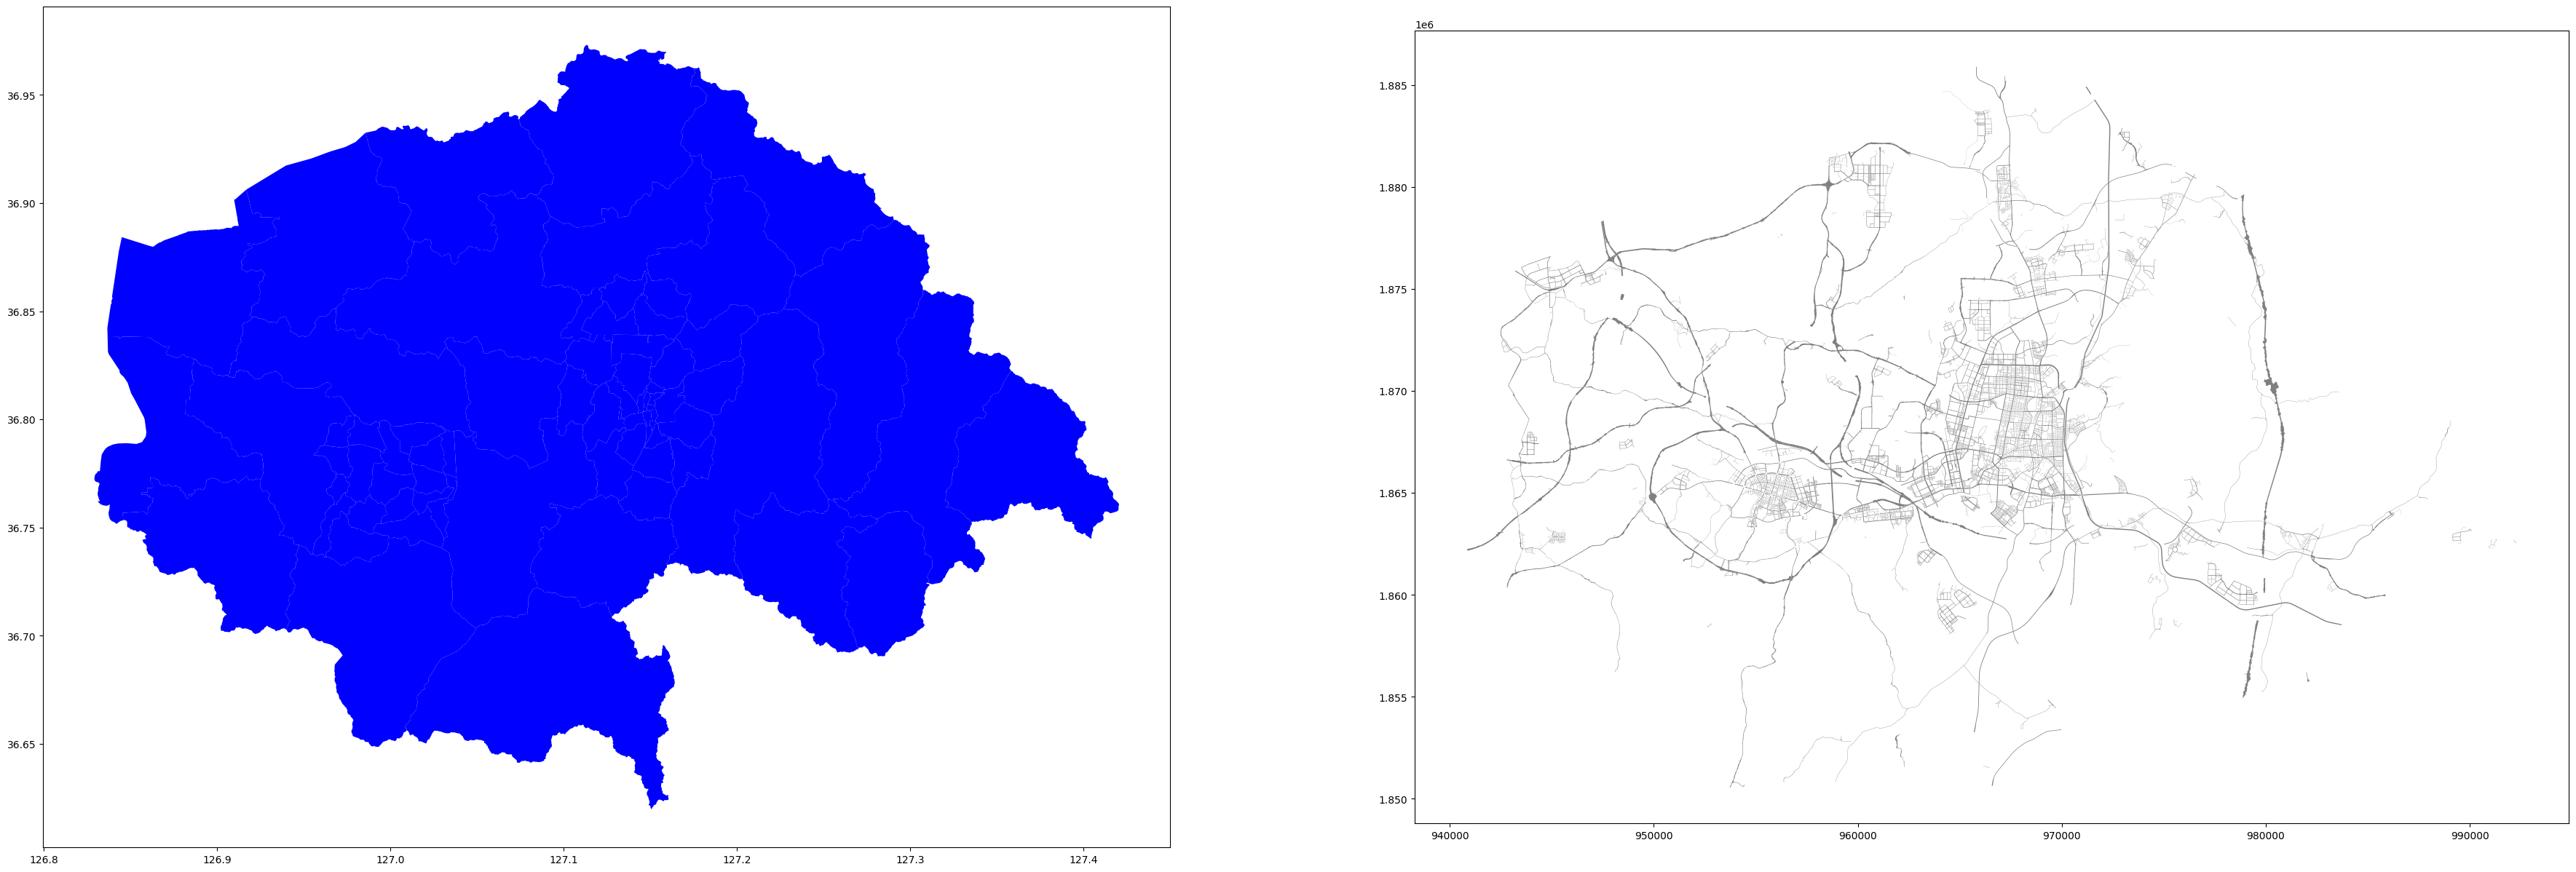

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(45,15))
cheonan.plot(color='blue',ax=ax[0])
cheonan_streets.plot(color='grey',ax=ax[1])

In [ ]:
# 천안시 및 아산시 초록색으로 채우기
cheonan = sig[sig['SIG_KOR_NM'].str.contains('천안|아산')]
cheonan_center = [cheonan.geometry.centroid.y.mean(), cheonan.geometry.centroid.x.mean()]

m = folium.Map(location=cheonan_center, zoom_start=12, tiles="OpenStreetMap")

folium.GeoJson(
    cheonan,
    style_function=lambda feature : {
        'fillColor': 'green',
        'color': 'green',
         'weight': 2,
         'fillOpacity': 0.5
    },
    tooltip = folium.GeoJsonTooltip(fields=['SIG_KOR_NM'], aliases=['지역:'])
).add_to(m)

m

In [ ]:
# 수요지 데이터
demand = pd.read_excel('수요지 정보.xlsx')

In [ ]:
# 파란색으로 수요지 시각화

for point, name in zip(demand_points, demand['명칭']):
  folium.CircleMarker(
      location=[point[1], point[0]],
      radius=5,
      color="blue",
      fill=True,
      fill_color="blue",
      fill_opacity=0.7,
      tooltip=name
      ).add_to(m)
m

## MCLP

In [ ]:
|import pulp
from haversine import haversine
import numpy as np
import folium

### 수요지, 후보지, 제약조건

In [ ]:
# 요인별 가중치 설정
# AHP로 나온 수요량 기준으로 상대적 가중치 설정
weight_map = {
    "병원": 4,
    "대학": 6,
    "산업단지": 4,
    "KTX": 9
}

In [ ]:
# 후보지인 천안 및 아산시 전체를 격자로 넣기
polygons = cheonan['geometry']

# 폴리곤 내부에서 일정 간격으로 점 생성
def generate_grid_points(poly, spacing):
    minx, miny, maxx, maxy = poly.bounds
    x_points = np.arange(minx, maxx, spacing)
    y_points = np.arange(miny, maxy, spacing)
    points = [Point(x, y) for x in x_points for y in y_points]
    return [point for point in points if poly.contains(point)]

facility_points = []
spacing = 0.03  # 점 간격을 조정 (이 값에 따라 후보지 밀도가 달라짐)
for poly in polygons:
    facility_points.extend(generate_grid_points(poly, spacing))

In [ ]:
# 수요 지점
demand_points = [
    (row.y,row.x,weight_map[row.요인])
    for _, row in demand.iterrows()
]

# 각 시설의 최대 수요 커버 반경 (km 단위)
coverage_distance = 1

# 최종적으로 선정할 입지의 갯수
num_facilities = 2

# Haversine을 이용하여 위경도 좌표를 기준으로 거리를 계산
distances = np.array(
    [
        [haversine((fy, fx), (dy, dx)) for dx, dy, _ in demand_points]
        for fx, fy in facility_points
    ]
)

facility_distances = np.array(
    [
        [haversine((fy1, fx1), (fy2, fx2)) for fx2, fy2 in facility_points]
        for fx1, fy1 in facility_points
    ]
)

In [ ]:
# 각 시설 입지 지점에 대응하는 이진 변수 (x[i] == 1 : 해당 지점이 선택됨 / x[i] == 0 : 해당 지점이 선택되지 않음
x = pulp.LpVariable.dicts(
    "facility", [(i) for i in range(len(facility_points))], cat="Binary"
)

# 각 입지 지점과 수요 지점의 쌍에 대응하는 이진 변수 딕셔너리를 생성
# 이 딕셔너리는 밑에서 추가할 제약을 바탕으로 해당 입지 지점이 선정되었다면, 계산에서 사용됨
y = pulp.LpVariable.dicts(
    "demand",
    [(i, j) for i in range(len(facility_points)) for j in range(len(demand_points))],
    cat="Binary",
)

In [ ]:
# 목적 함수 :  sum y_ij * 가중치를 최대화 함
problem += pulp.lpSum(
    [y[(i, j)] * demand_points[j][2] for i in range(len(facility_points)) for j in range(len(demand_points))]
)

In [ ]:
# 제약 1 : 최종적으로 선정할 입지의 갯수는 num_facilities와 동일해야함
problem += pulp.lpSum([x[i] for i in range(len(facility_points))]) == num_facilities

# 제약 2 : y[(i, j)]가 계산되려면, 앞서 x[i] 후보지가 선정되어야 함
# 제약 3 : i번째 후보지와 j번째 수요지 사이의 거리가 coverage_distance보다 작거나 같아야 수요를 커버 가능
for i in range(len(facility_points)):
    for j in range(len(demand_points)):
        problem += y[(i, j)] <= x[i]
        problem += y[(i, j)] <= (1e-4 < distances[i, j] <= coverage_distance)

# 제약 4 : 각 후보지 간의 거리가 최소 거리 이상이여야 함(후보지가 너무 몰리는 것을 방지)
# 최소 거리 제약 설정 (예: 1km = 1000m)
min_distance = 3  # km 단위

for i in range(len(facility_points)):
    for j in range(i + 1, len(facility_points)):
        if facility_distances[i, j] < min_distance:  # 두 후보지 간의 거리가 최소 거리보다 짧은 경우
            problem += x[i] + x[j] <= 1  # 둘 중 하나만 선택할 수 있도록 제약

수요 지점 반경 각각 1,000m, 2,000m, 3,000m로 실험

### 1. 반경 1,000m

In [ ]:
# solver를 통해 최적 해를 도출
problem.solve()

# 도출 결과
print("Status:", pulp.LpStatus[problem.status])
print("Objective:", problem.objective.value())

selected_facilities = [i for i in range(len(facility_points)) if x[i].value() == 1]
print("Selected facilities:", selected_facilities)

covered_demands = [
    (i, j)
    for i in range(len(facility_points))
    for j in range(len(demand_points))
    if y[(i, j)].value() == 1
]
print("Covered demands:", covered_demands)

Status: Optimal
Objective: 24.0
Selected facilities: [58, 120]
Covered demands: [(58, 46), (58, 54), (120, 36), (120, 60)]


In [ ]:
# 선정된 시설 입지 지점에 의해 커버되는 수요지는 검정색 테두리를 가진 점으로 변경
for p in covered_demands:
  demand_index = p[1]
  lat = demand_points[demand_index][1]  # 위도
  lng = demand_points[demand_index][0]  # 경도
  folium.CircleMarker(
      location=[lat, lng],
      radius=5,
      color="black",
      fill=True,
      fill_color="blue",
      fill_opacity=0.7,).add_to(m)
m

In [ ]:
# 최종 입지로 선정된 지점 빨간색 점으로 표시
# 커버하는 반경은 주황색 원으로 표시

for selected_fac in selected_facilities:
  lng = facility_points[selected_fac][0]
  lat = facility_points[selected_fac][1]

  folium.CircleMarker(
      location=(lat, lng),
      radius=5,
      color="red",
      fill=True,
      fill_color="red",
      fill_opacity=0.7,).add_to(m)

  folium.Circle(
        location=(lat, lng),
        radius=coverage_distance * 1000,  # Convert kilometers to meters
        color="orange",
        fill=True,
        fill_color="orange",
        fill_opacity=0.2,).add_to(m)
m

In [ ]:
# Coverage(%) 계산하기
# 전체 수요지 개수
total_demand_points = len(demand_points)

# 커버된 수요지 개수
covered_demand_points = len(set(p[1] for p in covered_demands))

# 커버된 수요지 비율
coverage_ratio = (covered_demand_points / total_demand_points) * 100

# 소수점 넷째자리에서 반올림
coverage_ratio_rounded = round(coverage_ratio, 4)

print(f"Coverage Ratio: {coverage_ratio_rounded}%")

Coverage Ratio: 6.4516%


### 2. 반경 2,000m

In [ ]:
# solver를 통해 최적 해를 도출
problem.solve()

# 도출 결과
print("Status:", pulp.LpStatus[problem.status])
print("Objective:", problem.objective.value())

selected_facilities = [i for i in range(len(facility_points)) if x[i].value() == 1]
print("Selected facilities:", selected_facilities)

covered_demands = [
    (i, j)
    for i in range(len(facility_points))
    for j in range(len(demand_points))
    if y[(i, j)].value() == 1
]
print("Covered demands:", covered_demands)

Status: Optimal
Objective: 51.0
Selected facilities: [58, 128]
Covered demands: [(58, 46), (58, 48), (58, 54), (58, 55), (58, 56), (128, 22), (128, 52), (128, 61)]


In [ ]:
# 선정된 시설 입지 지점에 의해 커버되는 수요지는 검정색 테두리를 가진 점으로 변경
for p in covered_demands:
  demand_index = p[1]
  lat = demand_points[demand_index][1]  # 위도
  lng = demand_points[demand_index][0]  # 경도
  folium.CircleMarker(
      location=[lat, lng],
      radius=5,
      color="black",
      fill=True,
      fill_color="blue",
      fill_opacity=0.7,).add_to(m)
m

In [ ]:
# 최종 입지로 선정된 지점 빨간색 점으로 표시
# 커버하는 반경은 주황 원으로 표시

for selected_fac in selected_facilities:
  lng = facility_points[selected_fac][0]
  lat = facility_points[selected_fac][1]

  folium.CircleMarker(
      location=(lat, lng),
      radius=5,
      color="red",
      fill=True,
      fill_color="red",
      fill_opacity=0.7,).add_to(m)

  folium.Circle(
        location=(lat, lng),
        radius=coverage_distance * 1000,  # Convert kilometers to meters
        color="orange",
        fill=True,
        fill_color="orange",
        fill_opacity=0.2,).add_to(m)
m

In [ ]:
# Coverage(%) 계산하기

# 전체 수요지 개수
total_demand_points = len(demand_points)

# 커버된 수요지 개수
covered_demand_points = len(set(p[1] for p in covered_demands))

# 커버된 수요지 비율
coverage_ratio = (covered_demand_points / total_demand_points) * 100

# 소수점 넷째자리에서 반올림
coverage_ratio_rounded = round(coverage_ratio, 4)

print(f"Coverage Ratio: {coverage_ratio_rounded}%")

Coverage Ratio: 12.9032%


### 3. 반경 3,000m

In [ ]:
# solver를 통해 최적 해를 도출
problem.solve()

# 도출 결과
print("Status:", pulp.LpStatus[problem.status])
print("Objective:", problem.objective.value())

selected_facilities = [i for i in range(len(facility_points)) if x[i].value() == 1]
print("Selected facilities:", selected_facilities)

covered_demands = [
    (i, j)
    for i in range(len(facility_points))
    for j in range(len(demand_points))
    if y[(i, j)].value() == 1
]
print("Covered demands:", covered_demands)

Status: Optimal
Objective: 67.0
Selected facilities: [14, 128]
Covered demands: [(14, 46), (14, 48), (14, 54), (14, 55), (14, 56), (128, 9), (128, 22), (128, 50), (128, 52), (128, 60), (128, 61)]


In [ ]:
# 선정된 시설 입지 지점에 의해 커버되는 수요지는 검정색 테두리를 가진 점으로 변경
for p in covered_demands:
  demand_index = p[1]
  lat = demand_points[demand_index][1]  # 위도
  lng = demand_points[demand_index][0]  # 경도
  folium.CircleMarker(
      location=[lat, lng],
      radius=5,
      color="black",
      fill=True,
      fill_color="blue",
      fill_opacity=0.7,).add_to(m)
m

In [ ]:
# 최종 입지로 선정된 지점 빨간색 점으로 표시
# 커버하는 반경은 주황색 원으로 표시

for selected_fac in selected_facilities:
  lng = facility_points[selected_fac][0]
  lat = facility_points[selected_fac][1]

  folium.CircleMarker(
      location=(lat, lng),
      radius=5,
      color="red",
      fill=True,
      fill_color="red",
      fill_opacity=0.7,).add_to(m)

  folium.Circle(
        location=(lat, lng),
        radius=coverage_distance * 1000,  # Convert kilometers to meters
        color="orange",
        fill=True,
        fill_color="orange",
        fill_opacity=0.2,).add_to(m)
m

In [ ]:
# Coverage(%) 계산하기

# 전체 수요지 개수
total_demand_points = len(demand_points)

# 커버된 수요지 개수
covered_demand_points = len(set(p[1] for p in covered_demands))

# 커버된 수요지 비율 (Coverage(%))
coverage_ratio = (covered_demand_points / total_demand_points) * 100

# 소수점 넷째자리에서 반올림
coverage_ratio_rounded = round(coverage_ratio, 4)

print(f"Coverage Ratio: {coverage_ratio_rounded}%")

Coverage Ratio: 17.7419%
